<a href="https://colab.research.google.com/github/janakg/era-s5/blob/main/S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

In [2]:
# import os

# # Define the repository and the target directory
# repo_url = 'https://github.com/janakg/era-s9.git'
# target_dir = '/content/era-s9'

# # Check if the directory already exists
# if not os.path.exists(target_dir):
#     # If it doesn't exist, clone the repo
#     !git clone {repo_url}
# else:
#     # If it exists, 'cd' into the directory and pull the latest changes
#     %cd {target_dir}
#     !git pull

# # Add the repository's directory to the system path
# import sys
# sys.path.append(target_dir)

# Import all utils functions
!pip install torch_lr_finder
from utils import *

In [3]:
# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)


# For reproducibility. SEED Random functions
SEED = 1
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available? True


In [4]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transforms = A.Compose([
    A.Normalize(mean, std),
    A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),  # 2 x 4 = 8 on each side
    A.RandomCrop(height=32, width=32, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=mean, mask_fill_value=None),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Normalize(mean, std),
    ToTensorV2()
])

class AlbumentationsCIFAR10Wrapper(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None):
        self.data = datasets.CIFAR10(root=root, train=train, download=download)
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = np.array(img)  # PIL Image to numpy array
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        return img, label

    def __len__(self):
        return len(self.data)

In [5]:
# Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomRotation(15),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        ])

# Test Phase transformations
# test_transforms = transforms.Compose([
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#                                        ])


In [6]:
train_data = AlbumentationsCIFAR10Wrapper(root='./data', train=True, 
                                          download=True, transform=train_transforms)

test_data = AlbumentationsCIFAR10Wrapper(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# dataloader arguments - something you'll fetch these from cmdprmt
batch_size=512
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


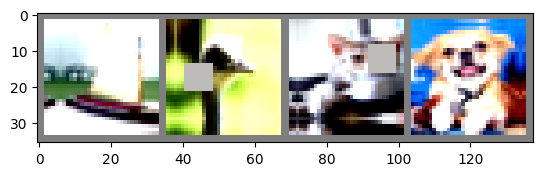

ship  bird  cat   dog  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# # Call the util function to show a batch of images
# import matplotlib.pyplot as plt
# fig = plt.figure()
# show_batch_images(plt, train_loader, 12, 3, 4)

In [9]:
# model imported from a module
from model import Net

In [10]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [11]:
model
# Use the hook
model.layer1.register_forward_hook(print_featuremaps_hook)

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.92E-02


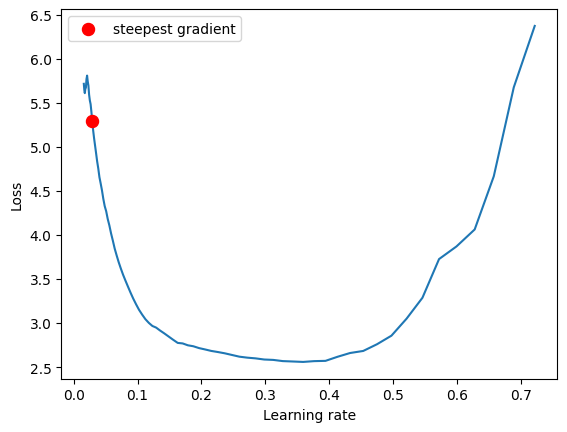

LRMAX: 0.029150530628251764
Epoch 1


Train: Loss=1.5013 Batch_id=97 Accuracy=30.20: 100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


Test set: Average loss: 0.0049, Accuracy: 1472/10000 (14.72%)

Epoch 2


Train: Loss=0.9572 Batch_id=97 Accuracy=55.88: 100%|██████████| 98/98 [00:10<00:00,  9.73it/s]


Test set: Average loss: 0.0027, Accuracy: 5276/10000 (52.76%)

Epoch 3


Train: Loss=0.8420 Batch_id=97 Accuracy=67.62: 100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Test set: Average loss: 0.0022, Accuracy: 6034/10000 (60.34%)

Epoch 4


Train: Loss=0.8343 Batch_id=97 Accuracy=71.51: 100%|██████████| 98/98 [00:10<00:00,  9.68it/s]


Test set: Average loss: 0.0019, Accuracy: 6639/10000 (66.39%)

Epoch 5


Train: Loss=0.8275 Batch_id=97 Accuracy=73.55: 100%|██████████| 98/98 [00:09<00:00,  9.87it/s]


Test set: Average loss: 0.0017, Accuracy: 7137/10000 (71.37%)

Epoch 6


Train: Loss=0.7616 Batch_id=97 Accuracy=74.21: 100%|██████████| 98/98 [00:09<00:00,  9.89it/s]


Test set: Average loss: 0.0024, Accuracy: 5564/10000 (55.64%)

Epoch 7


Train: Loss=0.6392 Batch_id=97 Accuracy=74.81: 100%|██████████| 98/98 [00:09<00:00,  9.89it/s]


Test set: Average loss: 0.0020, Accuracy: 6526/10000 (65.26%)

Epoch 8


Train: Loss=0.6936 Batch_id=97 Accuracy=74.85: 100%|██████████| 98/98 [00:10<00:00,  9.78it/s]


Test set: Average loss: 0.0023, Accuracy: 6106/10000 (61.06%)

Epoch 9


Train: Loss=0.7760 Batch_id=97 Accuracy=74.71: 100%|██████████| 98/98 [00:09<00:00,  9.94it/s]


Test set: Average loss: 0.0018, Accuracy: 6679/10000 (66.79%)

Epoch 10


Train: Loss=0.7448 Batch_id=97 Accuracy=74.59: 100%|██████████| 98/98 [00:10<00:00,  9.52it/s]


Test set: Average loss: 0.0017, Accuracy: 7200/10000 (72.00%)

Epoch 11


Train: Loss=0.7483 Batch_id=97 Accuracy=74.99: 100%|██████████| 98/98 [00:09<00:00, 10.05it/s]


Test set: Average loss: 0.0015, Accuracy: 7299/10000 (72.99%)

Epoch 12


Train: Loss=0.7462 Batch_id=97 Accuracy=75.37: 100%|██████████| 98/98 [00:09<00:00,  9.98it/s]


Test set: Average loss: 0.0014, Accuracy: 7563/10000 (75.63%)

Epoch 13


Train: Loss=0.7529 Batch_id=97 Accuracy=75.57: 100%|██████████| 98/98 [00:09<00:00,  9.83it/s]


Test set: Average loss: 0.0017, Accuracy: 7062/10000 (70.62%)

Epoch 14


Train: Loss=0.7443 Batch_id=97 Accuracy=75.75: 100%|██████████| 98/98 [00:09<00:00,  9.92it/s]


Test set: Average loss: 0.0015, Accuracy: 7400/10000 (74.00%)

Epoch 15


Train: Loss=0.6698 Batch_id=97 Accuracy=75.83: 100%|██████████| 98/98 [00:10<00:00,  9.50it/s]


Test set: Average loss: 0.0023, Accuracy: 5990/10000 (59.90%)

Epoch 16


Train: Loss=0.7238 Batch_id=97 Accuracy=75.55: 100%|██████████| 98/98 [00:09<00:00,  9.93it/s]


Test set: Average loss: 0.0015, Accuracy: 7431/10000 (74.31%)

Epoch 17


Train: Loss=0.6565 Batch_id=18 Accuracy=76.61:  19%|█▉        | 19/98 [00:02<00:10,  7.61it/s]


KeyboardInterrupt: 

In [13]:
num_epochs = 24
max_lr_epoch = 5

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)  # you can adjust learning rate as needed
criterion = nn.CrossEntropyLoss() # reduction='none' // it can be sum also

LRMAX = get_lr(
          model,
          train_loader,
          optimizer,
          criterion,
          device)

print("LRMAX:", LRMAX)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=LRMAX,
                                          steps_per_epoch=len(train_loader),
                                          epochs=num_epochs,
                                          pct_start=max_lr_epoch/num_epochs,
                                          div_factor=10,
                                          final_div_factor=100,
                                          three_phase=False,
                                  )



for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_succeeded, train_processed, train_loss = train(model, device, train_loader, optimizer, criterion)
  train_acc.append(100 * train_succeeded/train_processed)
  train_losses.append(train_loss / len(train_loader))

  test_succeeded, test_loss = test(model, device, test_loader, criterion)
  test_acc.append(100. * test_succeeded / len(test_loader.dataset))
  test_losses.append(test_loss)

  scheduler.step()

In [ ]:
# Plots
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

In [ ]:
image = images[9]
imshow(image)

In [ ]:
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

In [ ]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()